# Import necessary libraries 


In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum
import matplotlib.pyplot as plt



# Create a spark Session

In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("CA01_Sem_02").getOrCreate()

24/03/15 21:34:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Data_Ingestion Module
 To leverage the use of hadoop,  this module was created to read the csv files into a pyspark dataframe and save on hadoop hdfs system

In [41]:

# data_ingestion function: Loads all CSV files in a directory using PySpark and saves them to a specified output path on HDFS.
# Args: 
    # path: Path to the directory containing CSV files  
    # hd_path: Hadoop path on HDFS to save the processed files

def data_ingestion( path, hd_path):
    
    try:
        # Read all files in the directory matching the CSV extension (*.csv)
        df = spark.read.csv(path, header=True, inferSchema = True)

        # Save the DataFrame to Hadoop server - HDFS
        df.write.mode("overwrite").csv(hd_path, header=True)
        print('Data Ingestion Completed')

    except Exception as e:
        print("An error occurred:", e)
    
    
    

# Running the data_ingestion function

In [4]:
pwd


'/home/hduser/Documents/CA01_Sem_02_MSc_Data_Analytics'

In [42]:

# path to directory where the files are
path = "file:///home/hduser/Documents/CA01_Sem_02_MSc_Data_Analytics/*.csv"

# path where the files should be saved on hadoop
hd_path = "/user/hduser/bike_data/"

# Call the processing function
data_ingestion(path, hd_path)


Data Ingestion Completed


# Load data from hadoop

In [9]:

hd_path = "/user/hduser/bike_data/"

try:
   

  # Read the CSV files using the specified path
  df = spark.read.csv(hd_path, header = True, inferSchema = True)

  # Print the first few rows of the DataFrame (optional)
  df.show(2)

   
except Exception as e:
    print("An error occurred:", str(e))


+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|20CAF4CAD9186B1C|  docked_bike|2023-03-26 16:52:35|2023-03-26 17:22:08|Washington & Inde...|           31272|15th St & Constit...|         31321|38.886978|-77.013769|        38.892244|        -77.033234|       casual|
|695D9110D59A0A42| classic_bike|2023-03-28 16:51:30|2023-03-28 17:06:32|      11th & C St SE|           31659|D St & Marylan

In [10]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



### Checking the shape of the dataframe\


In [11]:
print((df.count(), len(df.columns)))

(4467334, 13)


When it comes to using RNNs for time series forecasting or analysis, the data structure must have some level of consistency, as each row of the dataset represents one trip, only  a new column was created to represent the tripa and only  date and trips were selected from the dataset

In [14]:
trips = df.select("started_at")

In [20]:
trips = trips.withColumn("trips", lit(1))

In [23]:
trips.show(3)

+-------------------+-----+
|         started_at|trips|
+-------------------+-----+
|2023-03-26 16:52:35|    1|
|2023-03-28 16:51:30|    1|
|2023-03-28 19:25:55|    1|
+-------------------+-----+
only showing top 3 rows



In [26]:
trips.printSchema()

root
 |-- started_at: timestamp (nullable = true)
 |-- trips: integer (nullable = false)



In [30]:
window_spec = window(trips['started_at'], "1 day")
daily_df = trips.groupBy(window_spec).agg(sum("trips").alias("total_trips"))


In [35]:
daily_df = daily_df.orderBy("window")

In [39]:
daily_df.show(10)

+--------------------+-----------+
|              window|total_trips|
+--------------------+-----------+
|{2023-01-01 00:00...|       6787|
|{2023-01-02 00:00...|       7240|
|{2023-01-03 00:00...|       7559|
|{2023-01-04 00:00...|       7791|
|{2023-01-05 00:00...|       8409|
|{2023-01-06 00:00...|       6719|
|{2023-01-07 00:00...|       7122|
|{2023-01-08 00:00...|       5176|
|{2023-01-09 00:00...|       6520|
|{2023-01-10 00:00...|       7303|
+--------------------+-----------+
only showing top 10 rows



In [43]:
daily_df.describe().show()

+-------+------------------+
|summary|       total_trips|
+-------+------------------+
|  count|               365|
|   mean|12239.271232876712|
| stddev|3994.0335144678165|
|    min|              2369|
|    max|             20258|
+-------+------------------+



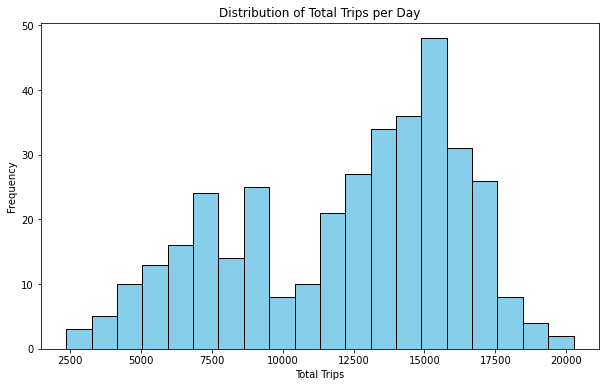

In [45]:
# Converting PySpark DataFrame to Pandas DataFrame
pandas_df = daily_df.toPandas()

# Plotting a histogram
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['total_trips'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Trips per Day')
plt.xlabel('Total Trips')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [59]:
trips = pandas_df.iloc[:,-1]

In [63]:
type(trips)

pandas.core.series.Series

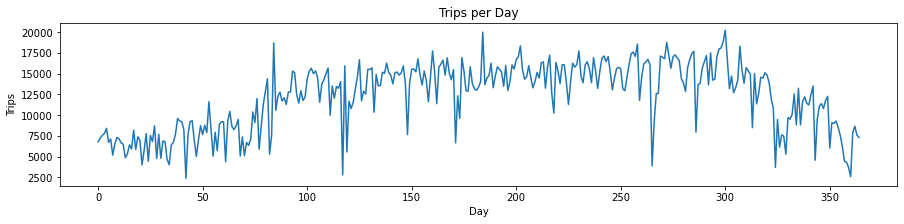

In [68]:
plt.figure(figsize=(15, 3))

trips.plot(kind='line') 

plt.title("Trips per Day")
plt.xlabel("Day")
plt.ylabel("Trips")
plt.grid(False)
plt.show()